In [41]:
import glob

files = glob.glob('*.mp4')
files

['Dropfall_p6_c1_AR1.0_cropped.mp4', 'Dropfall_p6_c1_AR1.0_cropped_2.mp4']

In [42]:
import cv2 


object_detector = cv2.createBackgroundSubtractorMOG2() #MOG2 is a method like KNN

cap = cv2.VideoCapture(files[-1])

centers = []

while True:
  
    ret, frame = cap.read()

    if ret:

        # mask_color = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # _, mask = cv2.threshold(blurred, 250,255, cv2.THRESH_BINARY)

        blurred = cv2.GaussianBlur(frame, (11, 11), 0)
        mask = object_detector.apply(blurred)
        _, mask = cv2.threshold(mask, 254,255, cv2.THRESH_BINARY)
        # mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)    
        
        # # Naming a window 
        # cv2.namedWindow("Blurred", cv2.WINDOW_NORMAL) 
        # # Using resizeWindow() 
        # cv2.resizeWindow("Blurred", 600, 400) 
        # cv2.imshow("Blurred", mask)

        contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        center = None

        # only proceed if at least one contour was found
        if len(contours) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(contours, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # only proceed if the radius meets a minimum size
            if radius>100 and radius<500:
                # draw the circle and centroid on the frame,
                # then update the list of tracked points
                cv2.circle(frame, (int(x), int(y)), int(radius),(0, 255, 255), 2)
                cv2.circle(frame, center, 3, (0, 0, 255), -1)
                # cv2.putText(frame,"centroid", (center[0]+10,center[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.4,(0, 0, 255),1)
                # cv2.putText(frame,"("+str(center[0])+","+str(center[1])+")", (center[0]+10,center[1]+15), cv2.FONT_HERSHEY_SIMPLEX, 0.4,(0, 0, 255),1)
                centers.append(center)


        # Naming a window 
        cv2.namedWindow("Frame", cv2.WINDOW_NORMAL) 
        # Using resizeWindow() 
        cv2.resizeWindow("Frame", 600, 400) 
        
        cv2.imshow("Frame", frame)

    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

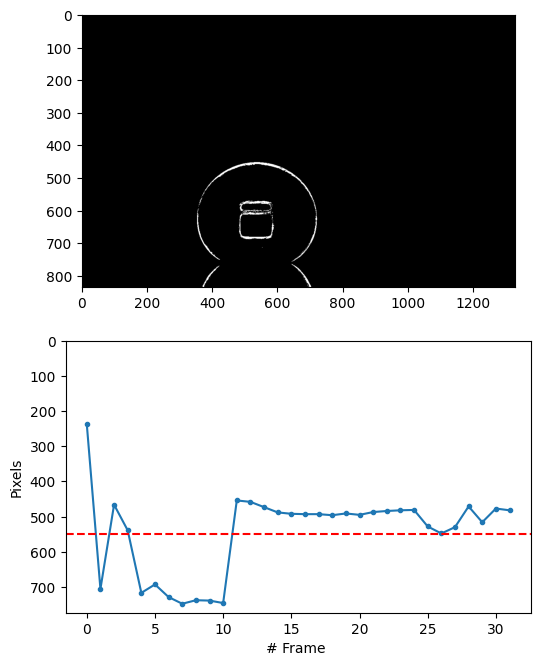

In [43]:
import numpy as np
import matplotlib.pyplot as plt

scale = 1/66  #mm/px (1000 µm == 66 px)

y = np.array(centers)
# p = (y[:,0]+y[:,1])*0.5

t0 = np.arange(0,len(y))

plt.figure(figsize=(6,12))
plt.subplot(311)
plt.imshow(mask, cmap='gray') #to check values

plt.subplot(312)
plt.plot(t0,y[:,1],'.-')
# plt.plot(t0,p,'.-')
plt.xlabel('# Frame ')
plt.ylabel('Pixels')
plt.axhline(550,color='red',linestyle='dashed')
plt.ylim(0,)
plt.gca().invert_yaxis()




(0.0, 4.1446969696969695)

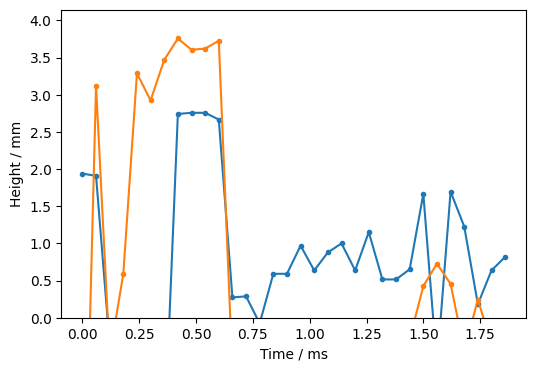

In [44]:
fps = 60
t = fps*t0*1e-3

tf = t-t[0] 
yf = (y-500)*scale
plt.figure(figsize=(6,4))
plt.plot(tf, yf,'.-')
plt.xlabel('Time / ms')
plt.ylabel('Height / mm')
plt.ylim(0,)

In [45]:
import pandas as pd

period = 6

df = pd.DataFrame({'tf':tf, 'y':y[:,1]})

df['period'] = np.ones(len(df))*period

df.to_excel('output'+str(period)+'.xlsx')

df.head()

,tf,y,period
0,0.00,237,6.0
1,0.06,706,6.0
2,0.12,466,6.0
3,0.18,539,6.0
4,0.24,717,6.0
